In [208]:
import numpy as np
import math
import matplotlib.pyplot as plt

from grad import dydx_x
from intercept import within_error, estimate_all_intercepts, nearest_point, is_in_interval

In [209]:
# estimate_all_intercepts(f, g, interval, n_tests = 100, n_iter = 100, error = 1e-10):

N_TESTS = 1000
N_ITER = 100
ERROR = 1e-10

In [210]:
def refraction_angle(i, n_before, n_after):
    return math.asin( (n_before / n_after) * math.sin(i) )

# Returns angles between [-pi, +pi]
def angle_in_range(theta): 
    theta = theta % (2 * math.pi)
    if theta <= math.pi:
        return theta
    else:
        return theta - (2 * math.pi)
    
def refraction_angle_from_norm(theta_ray, theta_norm, n_before, n_after):
    
    norm_opposite_to_ray = False
    
    theta_ray = angle_in_range(theta_ray)
    theta_norm = angle_in_range(theta_norm)
    theta_i = theta_norm - theta_ray
    if (theta_i < - math.pi / 2) or (theta_i > math.pi / 2):
        norm_opposite_to_ray = True
    if norm_opposite_to_ray:
        theta_i = theta_i - math.pi    
    
    theta_ray_t = theta_norm - refraction_angle(theta_i, n_before, n_after)
    if norm_opposite_to_ray:
        theta_ray_t = theta_ray_t - math.pi
    return angle_in_range(theta_ray_t)

def reflected_angle_from_norm(theta_ray, theta_norm):
    
    norm_opposite_to_ray = False
    
    theta_ray = angle_in_range(theta_ray)
    theta_norm = angle_in_range(theta_norm)
    theta_i = theta_norm - theta_ray
    if (theta_i < - math.pi / 2) or (theta_i > math.pi / 2):
        norm_opposite_to_ray = True
    if norm_opposite_to_ray:
        theta_i = theta_i - math.pi
        
    return angle_in_range((theta_ray - math.pi) + 2 * theta_i)
    

def polar_to_cart(pos, angle):
    
    grad = math.tan(angle)
    const = pos[1] - (grad * pos[0])
    def f(x):
        return x * grad + const
    return f


def normal_angle(func, x):
    return (math.pi / 2) + math.atan( calc_diff(func, x) )


In [211]:
class Bound_line:
    def __init__(self, func, interval, is_less_than = True, n = 2):
        self.func = func
        self.interval = interval
        self.is_less_than = is_less_than
        self.n = n
        
    def isin(self, pos):
        return is_in_interval(pos, self.interval)
    
    def find_intercept(self, ray):
        
        ray_interval = self.interval.copy()
        
        if ray.is_moving_in_pos_x():
            ray_interval[0] = ray.start_pos[0]
        else:
            ray_interval[1] = ray.start_pos[0]
        
        all_intercepts =  estimate_all_intercepts( ray.ray_to_cart(), 
                                                  self.func, ray_interval, 
                                                  n_tests = N_TESTS, 
                                                  n_iter = N_ITER, 
                                                  error = ERROR)
        
        return nearest_point(ray.start_pos, all_intercepts, error = ERROR, exclude_current_pos = True)
        
    def get_norm_angle(self, x):
        return (math.pi / 2) + math.atan(calc_diff(self.func, x))
        
def n_tabs(n):
    tabs = ""
    for i in range(0, n):
        tabs+="\t"
    return tabs
    
class Light_ray:
    def __init__(self, pos, angle, level = 0):
        self.start_pos = pos
        self.angle = angle
        self.level = level
        
        
        self.end_pos = None
        self.refracted_ray = None
        self.reflected_ray = None
        
    def ray_to_cart(self):
        return polar_to_cart(self.start_pos, self.angle)

    def is_moving_in_pos_x(self):
        if (self.angle > math.pi / 2) or (self.angle < -math.pi / 2):
            return False
        else:
            return True
        
    def update_ray(self, bound_line):
        ray_intercept = bound_line.find_intercept(self)
        
        if ray_intercept is None:
            return False
        
        self.end_pos = ray_intercept
        
        norm_angle = bound_line.get_norm_angle(self.start_pos[0])
        refracted_angle = refraction_angle_from_norm(self.angle, norm_angle, 1, bound_line.n)
        reflected_angle = reflected_angle_from_norm(self.angle, norm_angle)
        
        self.refracted_ray = Light_ray(ray_intercept, refracted_angle, self.level + 1)
        self.reflected_ray = Light_ray(ray_intercept, reflected_angle, self.level + 1)
        
        return True
    
    def print_ray(self):
        print(f"{n_tabs(self.level)}start_pos: {self.start_pos}, end_pos: {self.end_pos}, angle: {self.angle}")
        if self.refracted_ray is not None:
            print(f"{n_tabs(self.level +1)}Refracted ray:")
            self.refracted_ray.print_ray()
            
        if self.reflected_ray is not None:
            print(f"{n_tabs(self.level +1)}Reflected ray: ")
            self.reflected_ray.print_ray()



class Ray:
    def __init__(self, start_pos, angle, current_n, nearest_boundary = None):
        self.start_pos = start_pos
        self.angle = angle
        self.nearest_boundary = nearest_boundary
        self.current_n = current_n
        
        
        self.end_pos = None
        self.refracted_ray = None
        self.reflected_ray = None
        
    def ray_to_cart(self):
        return polar_to_cart(self.start_pos, self.angle)
    
    def is_moving_in_pos_x(self):
        if (self.angle > math.pi / 2) or (self.angle < -math.pi / 2):
            return False
        else:
            return True
        
    def get_delta_x_and_y(self):
        return np.array([math.cos(angle), math.sin(angle)])
    
    def update_ray(self, clipping_distance):
        self.end_pos = self.nearest_boundary.find_intercept(self)
        
        # Add a very small distance to stop ray clipping to boundaries
        self.end_pos+= clipping_distance * get_delta_x_and_y(self)
        
        
        if ray_intercept is None:
            return False
        
        if self.nearest_boundary is None:
            return False
        
        new_n = 1
        
        if self.nearest_boundary.in_bound(self.end_pos):
            new_n = self.nearest_boundary.parent.n
        
        norm_angle = self.nearest_boundary.get_norm_angle(self.start_pos[0])
        refracted_angle = refraction_angle_from_norm(self.angle, norm_angle, 1, new_n)
        reflected_angle = reflected_angle_from_norm(self.angle, norm_angle)
        
        self.refracted_ray = Light_ray(ray_intercept, refracted_angle, self.level + 1)
        self.reflected_ray = Light_ray(ray_intercept, reflected_angle, self.level + 1)
        
        self.current_n = new_n
        
        return True 
    

class Boundary:
    def __init__(self, func, interval, is_less_than = True):
        
        self.func = func
        self.interval = interval
        self.is_less_than = is_less_than
        self.parent = None
        
    def set_parent(self, parent):
        self.parent = parent
        
    def in_bound(self, pos):
        if not is_in_interval(pos[0], self.interval):
            return False
        
        if (self.func(pos[0]) <= pos[1]) == self.is_less_than:
            return True
        
        return False
    

class Area:
    def __init__(self, n = 1, *boundaries):
        self.n = n
        self.bounds = boundaries
        
        for bound in self.bounds:
            bound.set_parent(self)
        
    
    def find_intercept(self, ray):
        
        
        
        

class Scene:
    def __init__(self, *areas):
        self.areas = areas
        
        
    def trace_ray(self, ray):

In [217]:

def curve_3(x):
    return x + math.sin(x)

ray1 = Light_ray(np.array([0, -1]), math.pi / 2)

line1 = Bound_line(curve_3, np.array([-100, 100]), True)



plane_wave = []

for i in range(-100, 100):
    ray = Light_ray(np.array([i / 100, 10]), 0)
    plane_wave.append (ray)
    
vals = []   
for i, ray in enumerate(plane_wave):
    ray.update_ray(line1)
    #ray.print_ray()

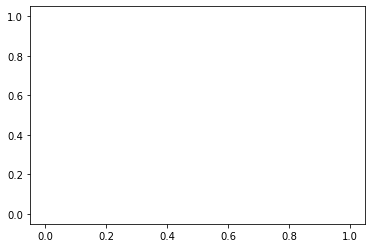

In [213]:
plt.plot(vals)